In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind
from scipy import stats
from matplotlib.gridspec import GridSpec
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import statsmodels.api as sm
from statsmodels.formula.api import ols


Import and clean data

In [29]:
df = pd.read_csv('Data/Salinité + Nappe.csv')
#Date Type
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
#Convert into numeric 
cols = ['Profondeur de nappe (cm)','Salinité à -30cm piézo (g/L)', 'Salinité en surface piézo (g/L)', 'Salinité en surface dehors (g/L)', 'Salinité eau inter -30cm (g/L)']
df[cols] = df[cols].apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
#Separate study sites
df_babin = df[df['Localisation'] == 'Babin '].drop(columns=['Localisation'])
df_RS = df[df['Localisation'] == 'RS'].drop(columns=['Parcelle', 'Localisation'])


stations_babin = ["RB", "RH", "T", "A"]
stations_RS = ["B", "H", "F"]
dates_babin = sorted(df_babin["Date"].unique())
dates_RS = sorted(df_RS["Date"].unique())


$\textbf{SALINITY AT 30CM IN PIEZOMETER PLOTS}$

Salinity at 30 cm depth as a function of date, grouped by station at Babin

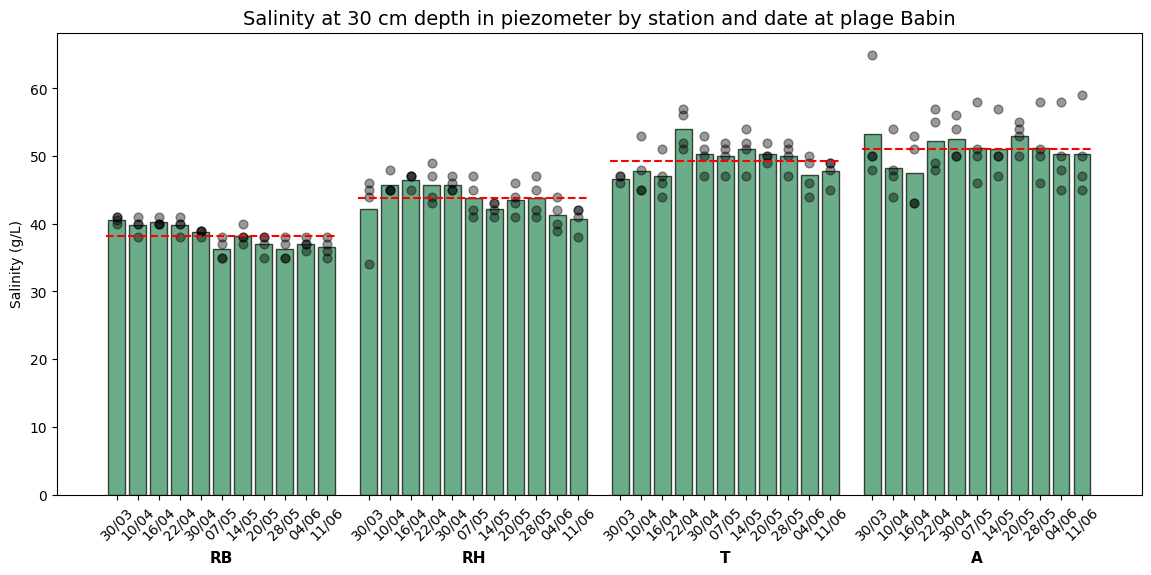

In [30]:
#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_babin[df_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data = station_df[station_df["Date"] == date]["Salinité à -30cm piézo (g/L)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    ax.hlines(
        y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("Salinity (g/L)")
ax.set_title("Salinity at 30 cm depth in piezometer by station and date at plage Babin", fontsize=14)

plt.savefig('Plot/Salinity_Babin.pdf', dpi=300, bbox_inches='tight')

ANOVA + Tukey for salinity
All data points from all plots and all measurement campaigns were grouped into 4 stations

38.21590909090909
43.75
49.325581395348834
50.97727272727273
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RB vs. RH: Custom statistical test, P_val:0.000e+00
RH vs. T: Custom statistical test, P_val:0.000e+00
T vs. A: Custom statistical test, P_val:9.870e-02


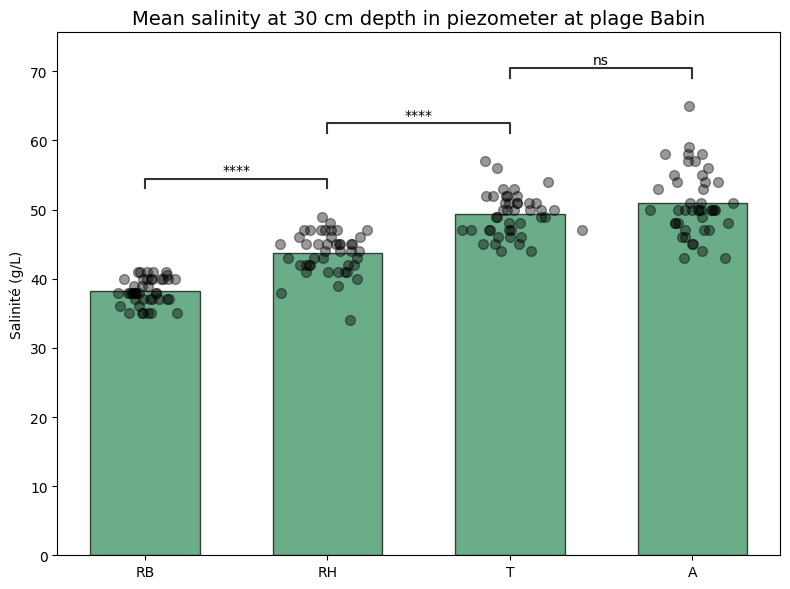

In [67]:

# Préparer data avec la bonne colonne Station
data = df_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_babin["Parcelle"].str.startswith(station)
    station_df = df_babin[station_mask]
    mean_depth = station_df["Salinité à -30cm piézo (g/L)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Salinité à -30cm piézo (g/L)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("Salinité (g/L)")
ax.set_title("Mean salinity at 30 cm depth in piezometer at plage Babin", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_Salinity_Babin.pdf', dpi=300, bbox_inches='tight')
plt.show()


Salinity at 30 cm depth as a function of date, grouped by station at RS

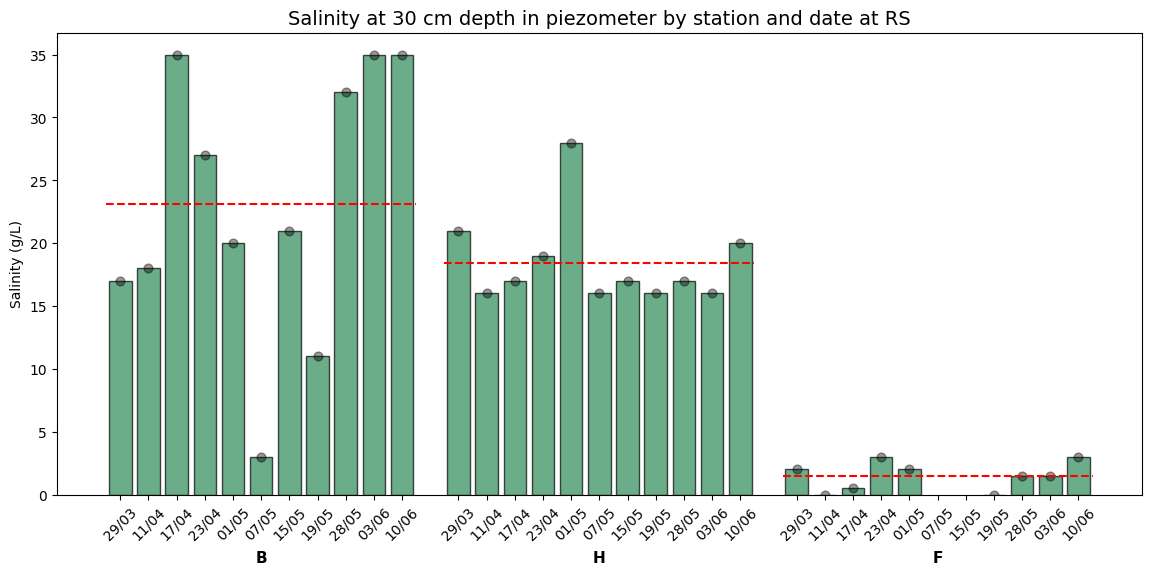

In [32]:
#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    group_center = i * (len(dates_RS) + spacing) + (len(dates_RS) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_RS):
        data = station_df[station_df["Date"] == date]["Salinité à -30cm piézo (g/L)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_RS) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_RS) + spacing) - 0.5
    end_x = start_x + len(dates_RS)

    ax.hlines(
        y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_RS] * len(stations_RS),  
    rotation=45,
    ha='center'
)


ax.set_ylabel("Salinity (g/L)")
ax.set_title("Salinity at 30 cm depth in piezometer by station and date at RS", fontsize=14)

plt.savefig('Plot/Salinity_RS.pdf', dpi=300, bbox_inches='tight')

ANOVA + Tukey for salinity
All data points from all plots and all measurement campaigns were grouped into 3 stations $\textbf{at RS}$

23.09090909090909
18.454545454545453
1.5
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. H: Custom statistical test, P_val:2.610e-01
H vs. F: Custom statistical test, P_val:0.000e+00
B vs. F: Custom statistical test, P_val:0.000e+00


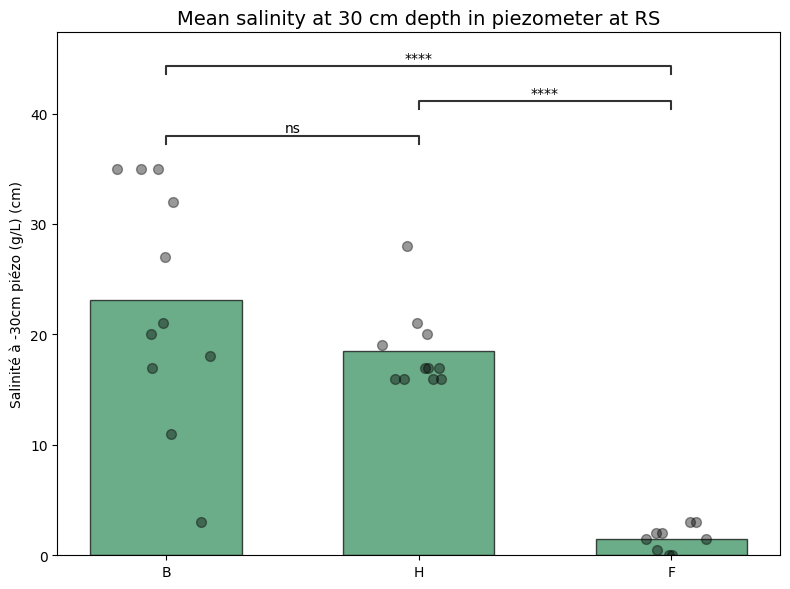

In [68]:

# Préparer data avec la bonne colonne Station
data = df_RS[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_RS))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    mean_depth = station_df["Salinité à -30cm piézo (g/L)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Salinité à -30cm piézo (g/L)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_RS)
ax.set_ylabel("Salinité à -30cm piézo (g/L) (cm)")
ax.set_title("Mean salinity at 30 cm depth in piezometer at RS", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("B", "H"), ("H", "F"), ("B", "F")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_Salinity_RS.pdf', dpi=300, bbox_inches='tight')
plt.show()


$\textbf{GROUNDWATER DEPTH IN PIEZOMETER PLOTS}$

Babin

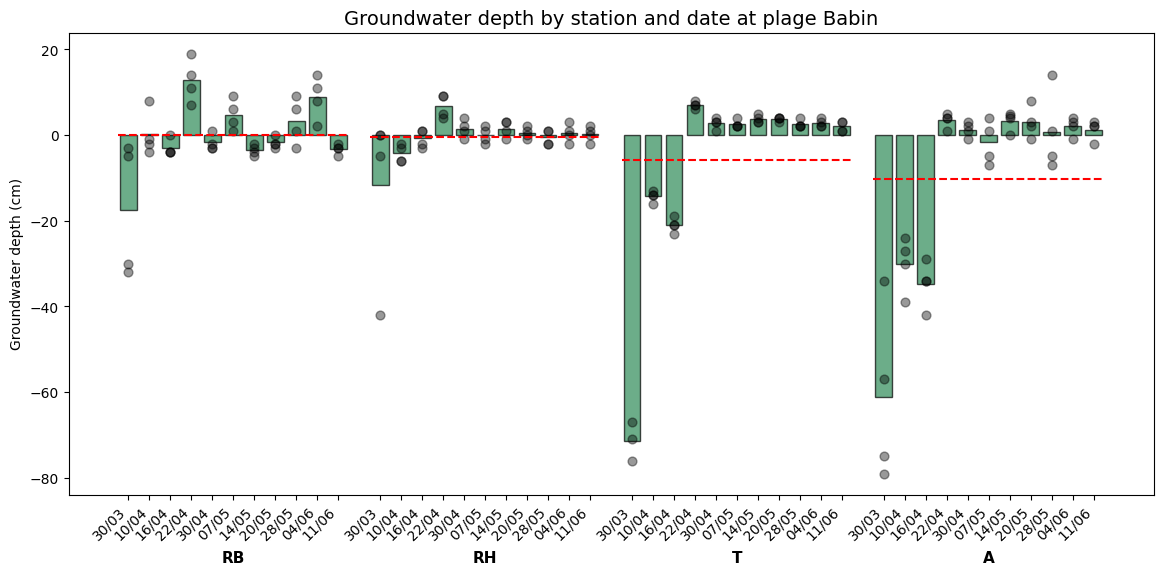

In [35]:

#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_babin[df_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data = station_df[station_df["Date"] == date]["Profondeur de nappe (cm)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    ax.hlines(
        y=station_df["Profondeur de nappe (cm)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Groundwater depth by station and date at plage Babin", fontsize=14)

plt.savefig('Plot/GroundWaterDepth_Babin.pdf', dpi=300, bbox_inches='tight')

RS

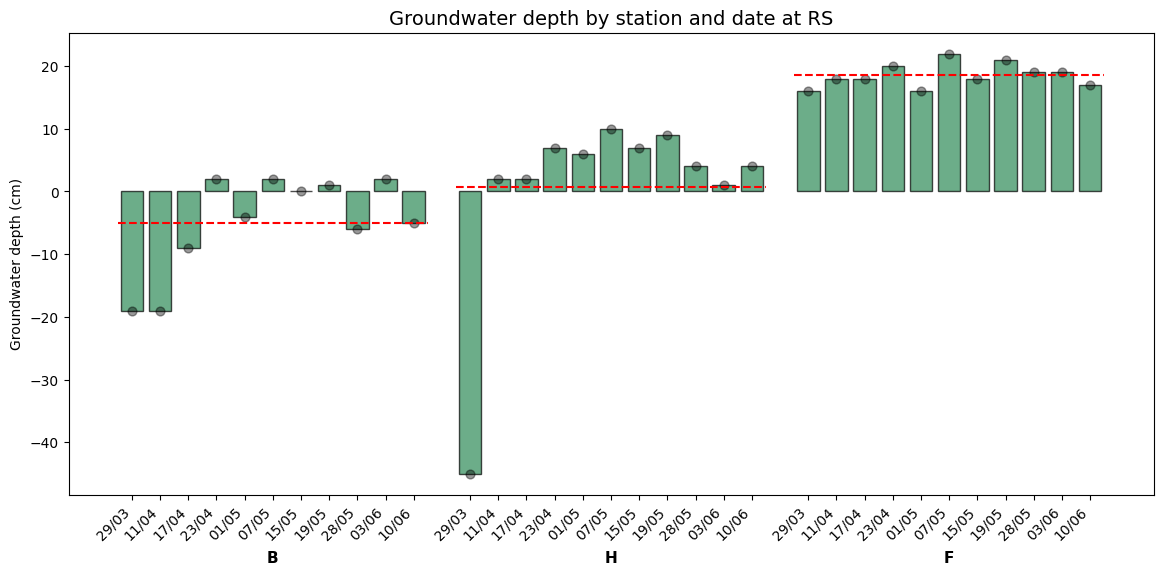

In [36]:

#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    group_center = i * (len(dates_RS) + spacing) + (len(dates_RS) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_RS):
        data = station_df[station_df["Date"] == date]["Profondeur de nappe (cm)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_RS) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_RS) + spacing) - 0.5
    end_x = start_x + len(dates_RS)

    ax.hlines(
        y=station_df["Profondeur de nappe (cm)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_RS] * len(stations_RS),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Groundwater depth by station and date at RS", fontsize=14)

plt.savefig('Plot/GroundWaterDepth_RS.pdf', dpi=300, bbox_inches='tight')

-5.0
0.6363636363636364
18.545454545454547
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. H: Custom statistical test, P_val:3.981e-01
H vs. F: Custom statistical test, P_val:7.000e-04
B vs. F: Custom statistical test, P_val:0.000e+00


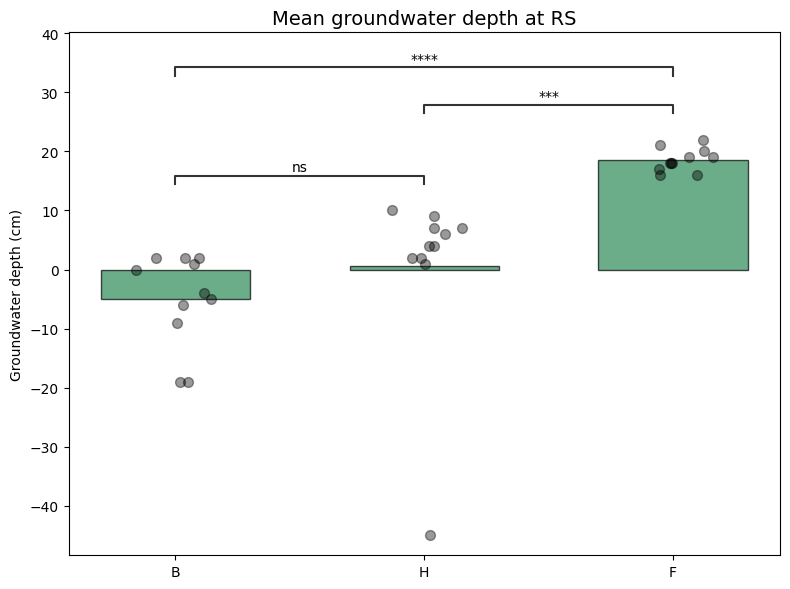

In [66]:

# Préparer data avec la bonne colonne Station
data = df_RS[["Profondeur de nappe (cm)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Profondeur de nappe (cm)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Profondeur de nappe (cm)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_RS))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    mean_depth = station_df["Profondeur de nappe (cm)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Profondeur de nappe (cm)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_RS)
ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Mean groundwater depth at RS", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("B", "H"), ("H", "F"), ("B", "F")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Profondeur de nappe (cm)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_GroundWaterDepth_RS.pdf', dpi=300, bbox_inches='tight')
plt.show()


MESURES HEBDO

In [39]:
df_month = pd.read_csv('Data/Mesures Hebdo.csv')
#Date Type
df_month["Date"] = pd.to_datetime(df_month["Date"], dayfirst=True)
#Convert into numeric 
cols2 = ["pH piezo 30cm","DO piezo 30cm","redox piezo 30cm","pH eau de surface","DO eau de surface","redox eau de surface","pH eau inter","DO eau inter","redox eau inter"]
df_month[cols2] = df_month[cols2].apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
#Separate study sites
df_month_babin = df_month[df_month['Localisation'] == 'Babin '].drop(columns=['Localisation'])
df_month_RS = df_month[df_month['Localisation'] == 'RS'].drop(columns=['Parcelle', 'Localisation'])


stations_babin = ["RB", "RH", "T", "A"]
stations_RS = ["B", "H", "F"]
dates_babin = sorted(df_month_babin["Date"].unique())
dates_RS = sorted(df_month_RS["Date"].unique())


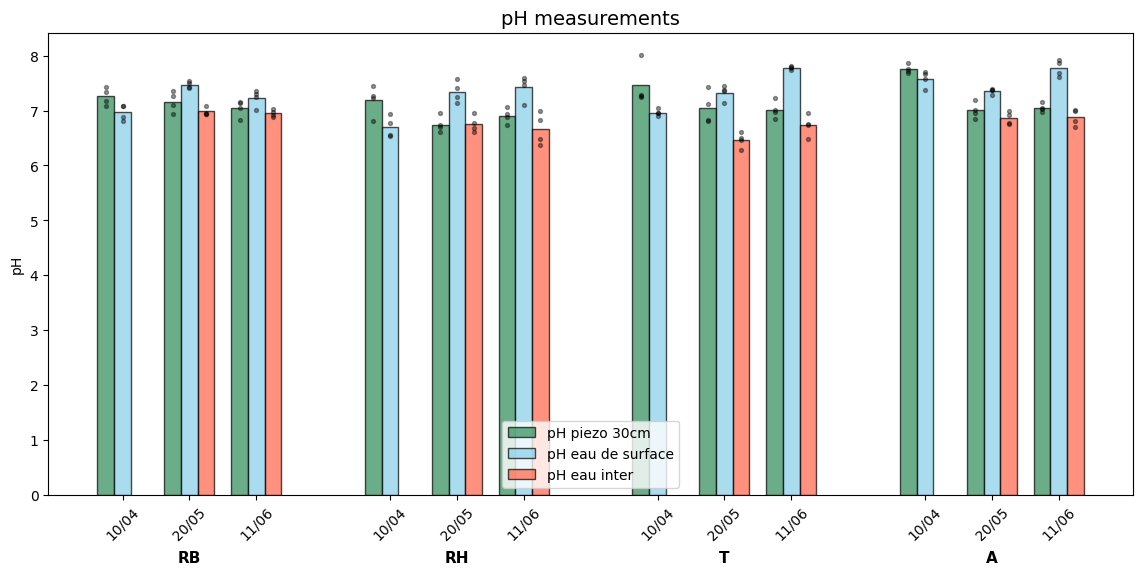

In [43]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["pH piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["pH eau de surface"]
        data3 = station_df[station_df["Date"] == date]["pH eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='pH piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='pH eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='pH eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("pH")
ax.set_title("pH measurements", fontsize=14)
ax.legend()
plt.savefig('Plot/pH_Babin.pdf', dpi=300, bbox_inches='tight')

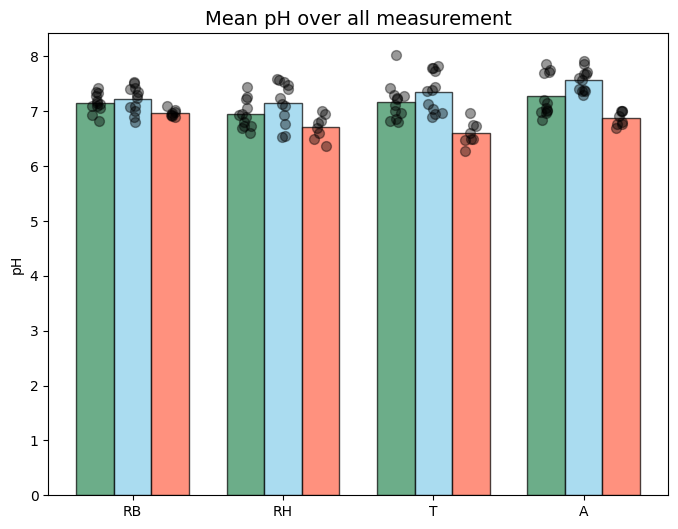

In [44]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_pH_piezo = station_df["pH piezo 30cm"].mean()
    mean_pH_surface = station_df["pH eau de surface"].mean()
    mean_pH_inter = station_df["pH eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_pH_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i], mean_pH_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i]+1/4, mean_pH_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black')
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["pH piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["pH eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["pH eau inter"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("pH")
ax.set_title("Mean pH over all measurement", fontsize=14)
ax.grid(False)
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_pH_Babin.pdf', dpi=300, bbox_inches='tight')

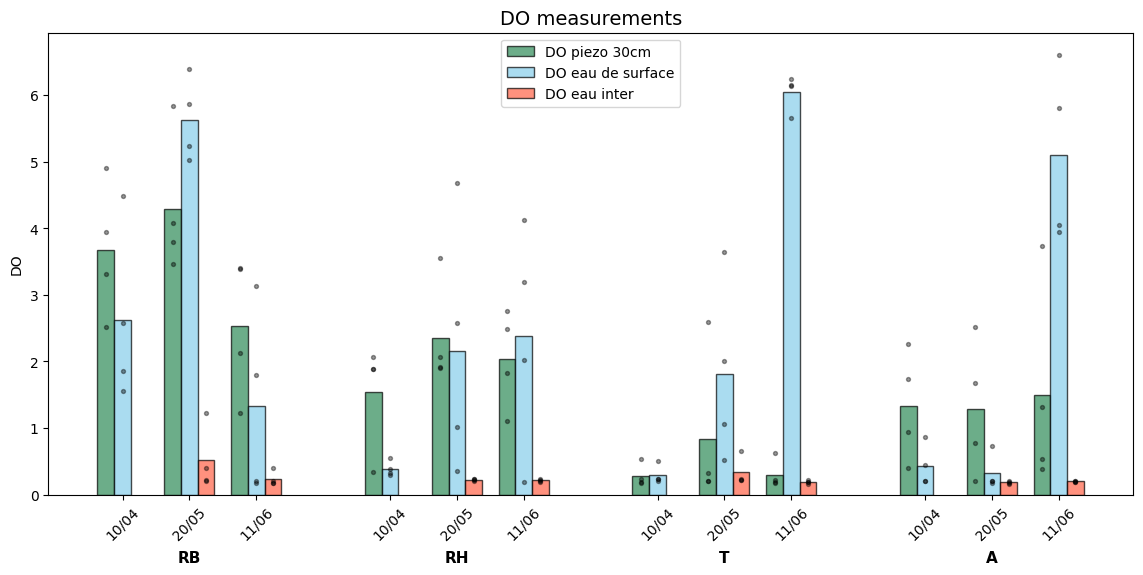

In [45]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["DO piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["DO eau de surface"]
        data3 = station_df[station_df["Date"] == date]["DO eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='DO piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='DO eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='DO eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

    
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("DO")
ax.set_title("DO measurements", fontsize=14)
ax.legend()
plt.savefig('Plot/DO_Babin.pdf', dpi=300, bbox_inches='tight')

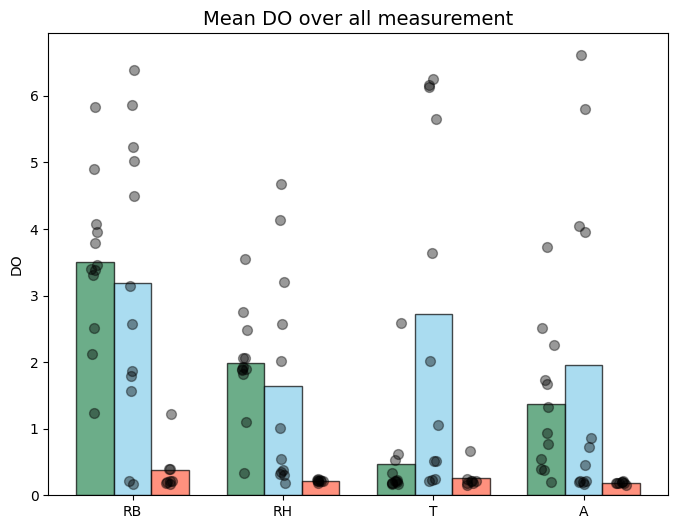

In [46]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_DO_piezo = station_df["DO piezo 30cm"].mean()
    mean_DO_surface = station_df["DO eau de surface"].mean()
    mean_DO_inter = station_df["DO eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_DO_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i], mean_DO_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i]+1/4, mean_DO_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black')
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["DO piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["DO eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["DO eau inter"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("DO")
ax.set_title("Mean DO over all measurement", fontsize=14)
ax.grid(False)
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_DO_Babin.pdf', dpi=300, bbox_inches='tight')

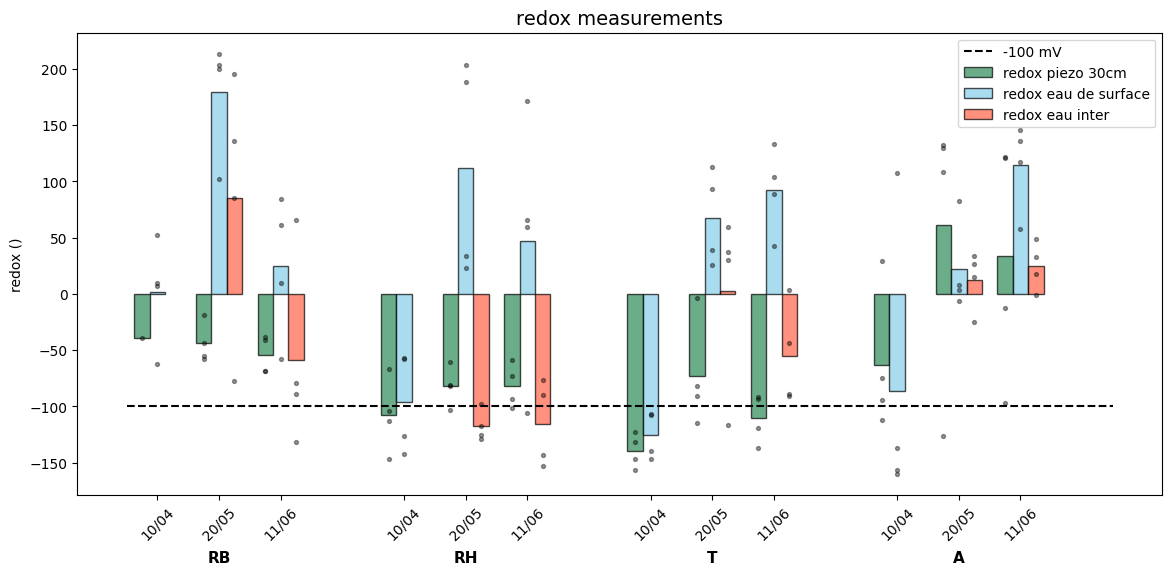

In [47]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["redox piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["redox eau de surface"]
        data3 = station_df[station_df["Date"] == date]["redox eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='redox piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='redox eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='redox eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

    
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)
ax.hlines(
    y=-100,
    xmin=-0.5,
    xmax=len(dates_babin) * len(stations_babin) + (len(stations_babin) - 1) * spacing + 0.5,  
    colors='black',
    linestyles='--',
    linewidth=1.5,
    label='-100 mV' 
)
ax.grid(False)
ax.set_ylabel("redox ()")
ax.set_title("redox measurements", fontsize=14)
ax.legend(loc='upper right')
plt.savefig('Plot/redox_Babin.pdf', dpi=300, bbox_inches='tight')

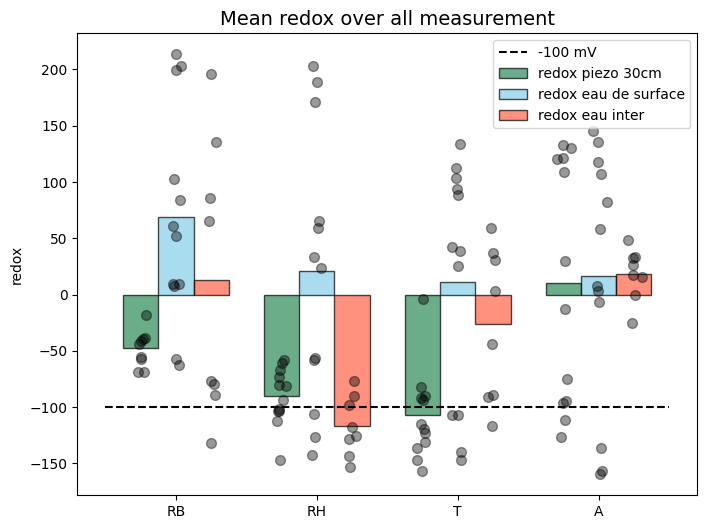

In [48]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(enredoxg=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_redox_piezo = station_df["redox piezo 30cm"].mean()
    mean_redox_surface = station_df["redox eau de surface"].mean()
    mean_redox_inter = station_df["redox eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_redox_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black',label='redox piezo 30cm' if i == 0 else "")
    ax.bar(x_pos[i], mean_redox_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black', label='redox eau de surface' if i == 0 else "")
    ax.bar(x_pos[i]+1/4, mean_redox_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black', label='redox eau inter' if i == 0 else "")
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["redox piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["redox eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["redox eau inter"], color='black', alpha=0.4, s=50)
ax.hlines(
    y=-100,
    xmin=-0.5,
    xmax= 3.5,
    colors='black',
    linestyles='--',
    linewidth=1.5,
    label='-100 mV'
)
ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("redox")
ax.set_title("Mean redox over all measurement", fontsize=14)
ax.grid(False)
ax.legend(loc='upper right')
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_redox_Babin.pdf', dpi=300, bbox_inches='tight')

In [49]:
numeric_columns = df_babin.select_dtypes(include=[np.number]).columns
df_moyennes_babin = df_babin.groupby('Parcelle')[numeric_columns].mean().reset_index()
numeric_columns_month = df_month_babin.select_dtypes(include=[np.number]).columns
df_moyennes_month_babin = df_month_babin.groupby('Parcelle')[numeric_columns_month].mean().reset_index()
df_babin_tot_mean = pd.merge(df_moyennes_babin, df_moyennes_month_babin, on='Parcelle')


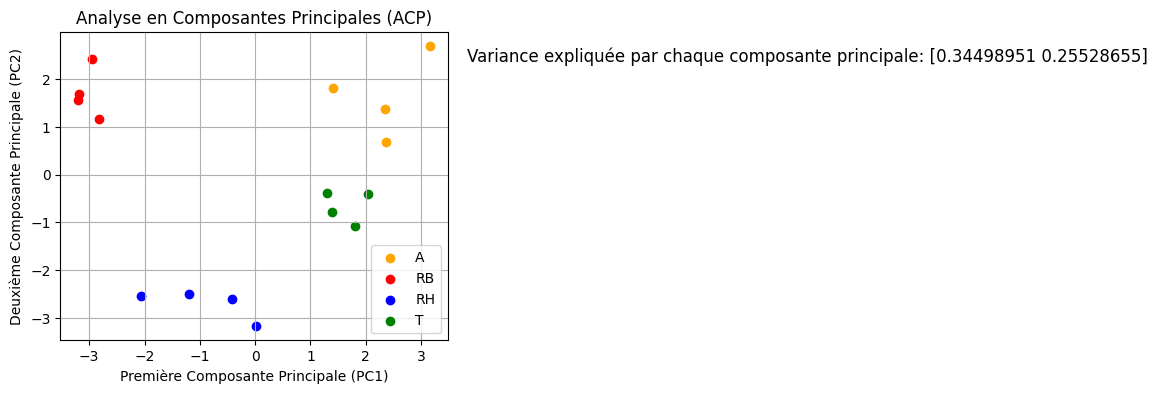

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

# Séparer les caractéristiques et les étiquettes
X = df_babin_tot_mean.drop('Parcelle', axis=1)
y = df_babin_tot_mean['Parcelle']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réaliser l'ACP
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Parcelle'] = y

colors = {
    'RB': 'red',
    'RH': 'blue',
    'T': 'green',
    'A': 'orange'
}

# Visualiser les résultats
plt.figure(figsize=(5, 4))
i=0
for parcelle in pca_df['Parcelle'].unique():
    prefix = re.match(r'([A-Z]+)', parcelle).group(1)
    # Utiliser la couleur correspondante si le préfixe est dans le dictionnaire, sinon utiliser une couleur par défaut
    color = colors.get(prefix, 'black')
    plt.scatter(pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC1'],
                pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC2'],
                label=prefix if i%4==0 else "", color=color)
    i+=1
# Pour éviter les doublons dans la légende
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))

plt.xlabel('Première Composante Principale (PC1)')
plt.ylabel('Deuxième Composante Principale (PC2)')
plt.title('Analyse en Composantes Principales (ACP)')
plt.text(1.05, 0.95, f'Variance expliquée par chaque composante principale: {pca.explained_variance_ratio_}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('Plot/PCA_Babin.pdf', dpi=300, bbox_inches='tight')
plt.show()



Contenu des composantes principales :
     Profondeur de nappe (cm)  Salinité à -30cm piézo (g/L)  \
PC1                 -0.352482                      0.440156   
PC2                 -0.179794                     -0.002190   

     Salinité en surface piézo (g/L)  Salinité en surface dehors (g/L)  \
PC1                         0.426446                         -0.042372   
PC2                         0.109028                          0.467402   

     Salinité eau inter -30cm (g/L)  pH piezo 30cm  DO piezo 30cm  \
PC1                        0.269122       0.146002      -0.334586   
PC2                       -0.211964       0.304329       0.162245   

     redox piezo 30cm  pH eau de surface  DO eau de surface  \
PC1          0.101065            0.35574          -0.181927   
PC2          0.300181            0.28976           0.264532   

     redox eau de surface  pH eau inter  DO eau inter  redox eau inter  
PC1             -0.236717     -0.202014     -0.152647         0.051652  
PC2  

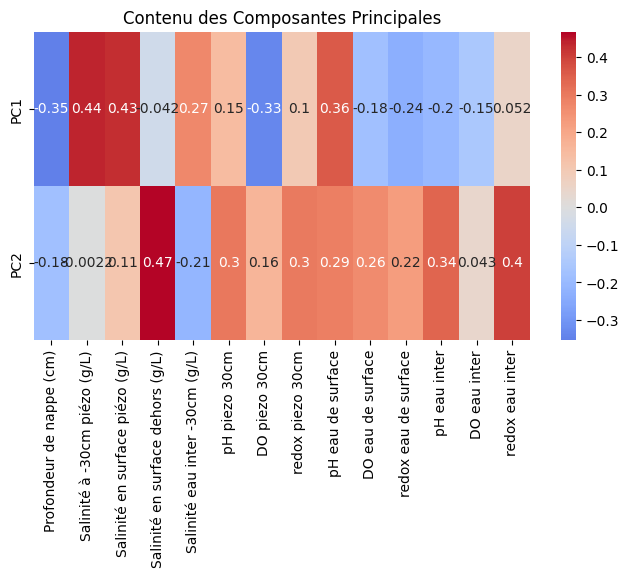

In [69]:
import pandas as pd

# Créer un DataFrame avec les composantes principales et les noms des caractéristiques
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])

print("Contenu des composantes principales :")
print(components_df)
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(components_df, annot=True, cmap='coolwarm', center=0)
plt.title('Contenu des Composantes Principales')
plt.savefig('Plot/PCA_Babin_correlations.pdf', dpi=300, bbox_inches='tight')

plt.show()


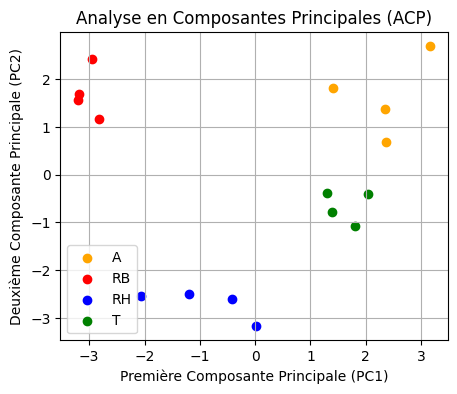

Variance expliquée par chaque composante principale: [3.44989509e-01 2.55286552e-01 1.08096343e-01 9.25616228e-02
 9.13973062e-02 3.93995003e-02 2.90969051e-02 1.57862207e-02
 1.22582457e-02 5.43010630e-03 3.56996294e-03 1.53029630e-03
 4.45009045e-04 1.52420507e-04]


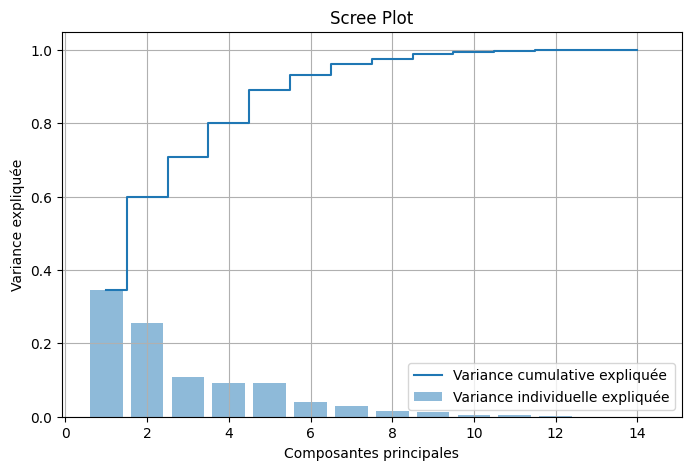

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

# Séparer les caractéristiques et les étiquettes
X = df_babin_tot_mean.drop('Parcelle', axis=1)
y = df_babin_tot_mean['Parcelle']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réaliser l'ACP
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])])
pca_df['Parcelle'] = y

# Visualiser les résultats de l'ACP
plt.figure(figsize=(5, 4))
colors = {
    'RB': 'red',
    'RH': 'blue',
    'T': 'green',
    'A': 'orange'
}
i = 0
for parcelle in pca_df['Parcelle'].unique():
    prefix = re.match(r'([A-Z]+)', parcelle).group(1)
    color = colors.get(prefix, 'black')
    plt.scatter(pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC1'],
                pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC2'],
                label=prefix if i % 4 == 0 else "", color=color)
    i += 1

plt.xlabel('Première Composante Principale (PC1)')
plt.ylabel('Deuxième Composante Principale (PC2)')
plt.title('Analyse en Composantes Principales (ACP)')
plt.legend()
plt.grid()
plt.show()

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Variance cumulative expliquée')
plt.ylabel('Variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Scree Plot')
plt.savefig('Plot/PCA_Babin_ScreePlot.pdf', dpi=300, bbox_inches='tight')

plt.legend()
plt.grid()
plt.show()
